In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.tensorboard import SummaryWriter

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file_path, transform=None):
        self.data = pd.read_csv(csv_file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype('float32').reshape((28, 28, 1))
        image = (image / 127.5) - 1.0
        label = int(self.data.iloc[idx, 0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [6]:
csv_file_path = '/project/jacobcha/nk643/gans/data/fashion-mnist_train.csv'
transform = transforms.ToTensor()  # Convert images to PyTorch tensors

mnist_dataset = MNISTDataset(csv_file_path, transform=transform)

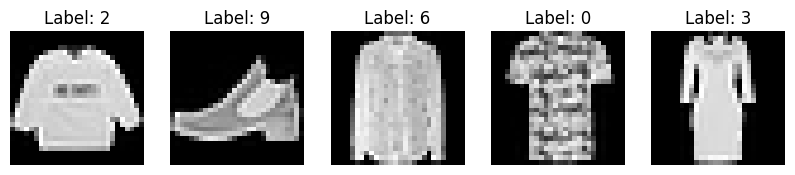

In [7]:
import matplotlib.pyplot as plt

def show_example_data(dataset, num_samples=5):
    plt.figure(figsize=(10, 2))
    
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.numpy().squeeze()  # Convert to numpy array and remove channel dimension for plotting

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.show()

# Assuming mnist_dataset is your MNISTDataset instance
show_example_data(mnist_dataset)


In [8]:
batch_size = 128
data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# Latent dimension of the random noise
LATENT_DIM = 100

# Number of channels, 1 for grayscale and 3 for color images
CHANNELS = 1  # Change to 3 if working with color images

# Size of the image
IMG_SIZE = 28

# Learning rate
LEARNING_RATE = 0.0002

# Beta1 hyperparam for Adam optimizers
BETA1 = 0.5

In [10]:
# Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, CHANNELS * IMG_SIZE * IMG_SIZE),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), CHANNELS, IMG_SIZE, IMG_SIZE)
        return x

In [11]:
# Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(CHANNELS * IMG_SIZE * IMG_SIZE, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [12]:
# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [13]:
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE)
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

In [12]:
class GAN(nn.Module):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def forward(self, real_images):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        noise = torch.randn(batch_size, self.latent_dim).to(device)
        fake = self.generator(noise)
        labels_real = torch.ones(batch_size, 1).to(device)
        labels_fake = torch.zeros(batch_size, 1).to(device)

        outputs_real = self.discriminator(real_images)
        loss_real = self.loss_fn(outputs_real, labels_real)
        
        outputs_fake = self.discriminator(fake.detach())
        loss_fake = self.loss_fn(outputs_fake, labels_fake)
        
        loss_D = (loss_real + loss_fake) / 2
        self.d_optimizer.zero_grad()
        loss_D.backward()
        self.d_optimizer.step()

        # Train Generator
        outputs_fake = discriminator(fake)
        loss_G = self.loss_fn(outputs_fake, labels_real)
        
        self.g_optimizer.zero_grad()
        loss_G.backward()
        self.g_optimizer.step()

        return {"d_loss": loss_D.item(), "g_loss": loss_G.item()}

    def compute_metrics(self, real_images):
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, self.latent_dim, device=real_images.device)

        # Compute predictions
        pred_real = self.discriminator(real_images)
        fake_images = self.generator(noise)
        pred_fake = self.discriminator(fake_images)

        # Calculate accuracy metrics
        real_accuracy = torch.mean((pred_real > 0.5).float())
        fake_accuracy = torch.mean((pred_fake <= 0.5).float())

        return {"real_accuracy": real_accuracy.item(), "fake_accuracy": fake_accuracy.item()}

In [13]:
# Loss function
loss_fn = nn.BCELoss()

In [14]:
gan = GAN(discriminator, generator, LATENT_DIM)

# Compile the DCGAN model
gan.compile(optimizer_D, optimizer_G, loss_fn)

In [15]:
class GANMonitor:
    def __init__(self, num_img=3, latent_dim=100, output_dir='/project/jacobcha/nk643/gans/'):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.output_dir = output_dir
        # Ensure the seed is on the same device as the generator
        self.seed =  torch.randn(batch_size, self.latent_dim).to(device)

    def on_epoch_end(self, epoch, generator):
        generator.eval()
        with torch.no_grad():
            # Generate images and move them to CPU for visualization
            generated_images = generator(self.seed).to('cpu')

            # Rescale images from [-1, 1] to [0, 255]
            generated_images = (generated_images * 127.5) + 127.5
            generated_images = generated_images.clamp(0, 255)
  
            # Plot and save images
            fig = plt.figure(figsize=(4, 4))
            for i in range(self.num_img):
                plt.subplot(4, 4, i + 1)
                plt.imshow(generated_images[i].squeeze(0), cmap='gray')
                plt.axis('off')
            plt.savefig(f'{self.output_dir}/output/normal-gan/epoch_{epoch:03d}.png')
            plt.show()

    def on_train_end(self, generator, discriminator):
        torch.save(generator.state_dict(), f'{self.output_dir}/checkpoints/normal-gan/generator.pth')
        torch.save(discriminator.state_dict(), f'{self.output_dir}/checkpoints/normal-gan/discriminator.pth')


Epoch [0/20] - D Loss: 0.302804, G Loss: 1.200090
Real Accuracy: 1.000000, Fake Accuracy: 0.645833


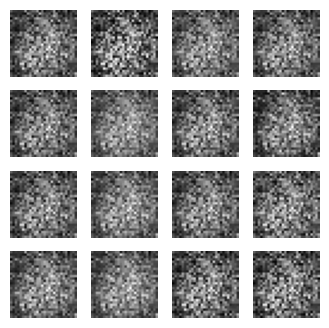

Epoch [1/20] - D Loss: 0.229248, G Loss: 5.620016
Real Accuracy: 0.895833, Fake Accuracy: 0.947917


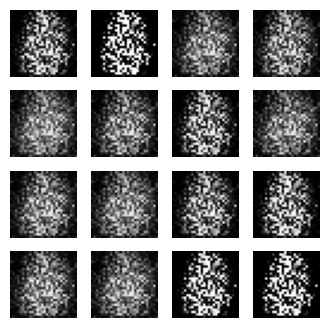

Epoch [2/20] - D Loss: 0.380869, G Loss: 2.839345
Real Accuracy: 0.708333, Fake Accuracy: 1.000000


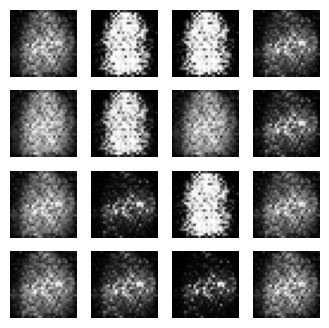

Epoch [3/20] - D Loss: 0.377907, G Loss: 3.074956
Real Accuracy: 0.812500, Fake Accuracy: 0.833333


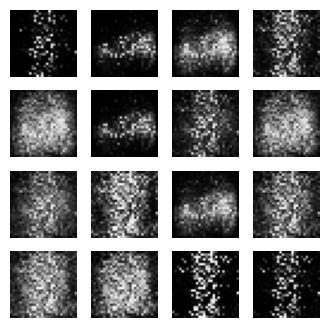

Epoch [4/20] - D Loss: 0.373925, G Loss: 2.695220
Real Accuracy: 0.802083, Fake Accuracy: 0.895833


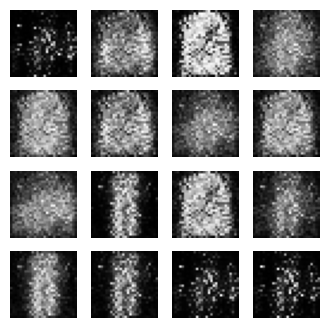

Epoch [5/20] - D Loss: 0.203191, G Loss: 3.055859
Real Accuracy: 0.875000, Fake Accuracy: 0.958333


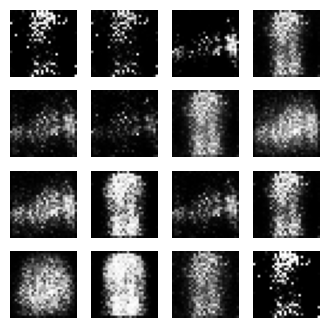

Epoch [6/20] - D Loss: 0.143835, G Loss: 3.785335
Real Accuracy: 0.927083, Fake Accuracy: 1.000000


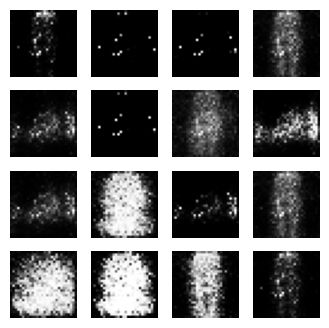

Epoch [7/20] - D Loss: 0.355360, G Loss: 3.255735
Real Accuracy: 0.822917, Fake Accuracy: 0.916667


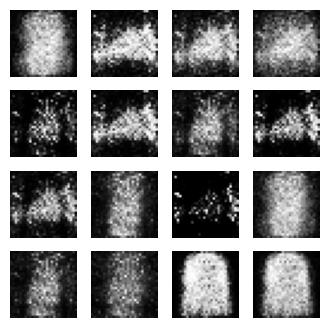

Epoch [8/20] - D Loss: 0.181843, G Loss: 3.602813
Real Accuracy: 0.927083, Fake Accuracy: 0.979167


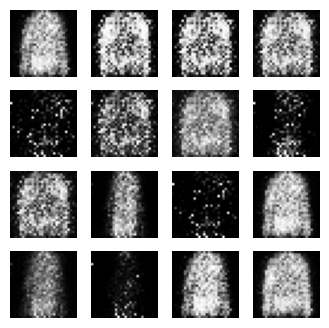

Epoch [9/20] - D Loss: 0.236748, G Loss: 2.648072
Real Accuracy: 0.895833, Fake Accuracy: 0.947917


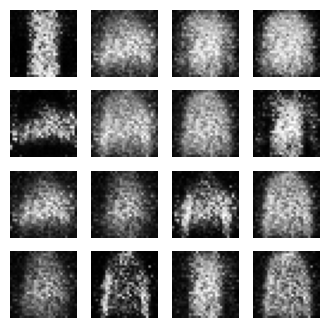

Epoch [10/20] - D Loss: 0.351578, G Loss: 2.511525
Real Accuracy: 0.854167, Fake Accuracy: 0.875000


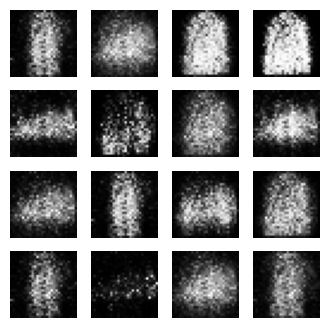

Epoch [11/20] - D Loss: 0.389378, G Loss: 3.731804
Real Accuracy: 0.812500, Fake Accuracy: 0.947917


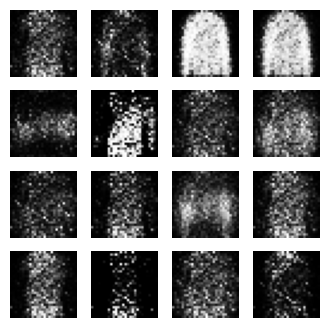

Epoch [12/20] - D Loss: 0.303783, G Loss: 2.131382
Real Accuracy: 0.895833, Fake Accuracy: 0.864583


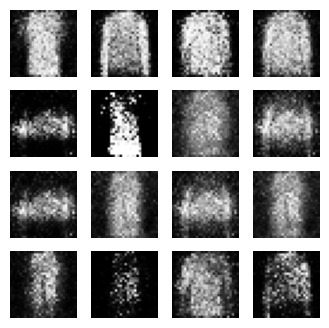

Epoch [13/20] - D Loss: 0.270762, G Loss: 2.299661
Real Accuracy: 0.875000, Fake Accuracy: 0.843750


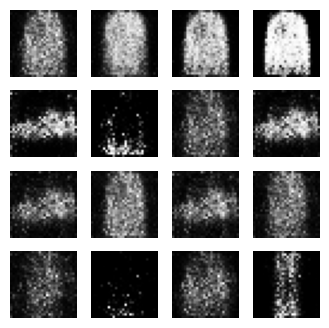

Epoch [14/20] - D Loss: 0.515555, G Loss: 1.650624
Real Accuracy: 0.760417, Fake Accuracy: 0.885417


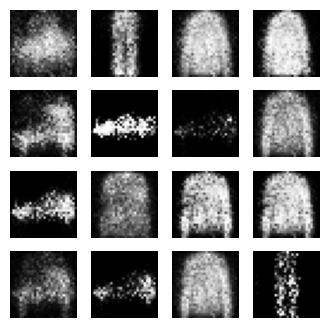

Epoch [15/20] - D Loss: 0.412889, G Loss: 1.866588
Real Accuracy: 0.822917, Fake Accuracy: 0.791667


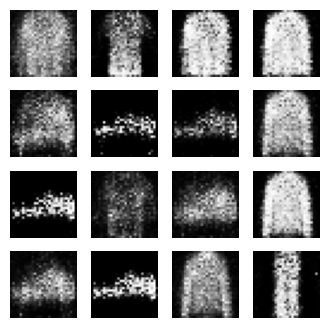

Epoch [16/20] - D Loss: 0.376537, G Loss: 1.600050
Real Accuracy: 0.843750, Fake Accuracy: 0.927083


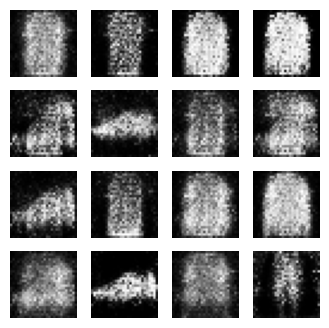

Epoch [17/20] - D Loss: 0.328280, G Loss: 2.003781
Real Accuracy: 0.833333, Fake Accuracy: 0.916667


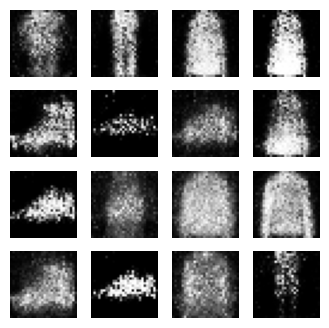

Epoch [18/20] - D Loss: 0.392894, G Loss: 1.728375
Real Accuracy: 0.781250, Fake Accuracy: 0.875000


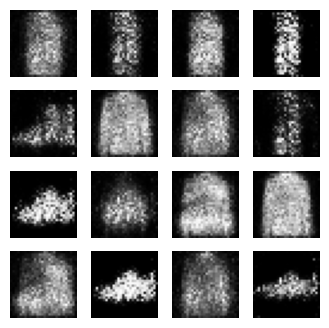

Epoch [19/20] - D Loss: 0.553084, G Loss: 1.760805
Real Accuracy: 0.656250, Fake Accuracy: 0.750000


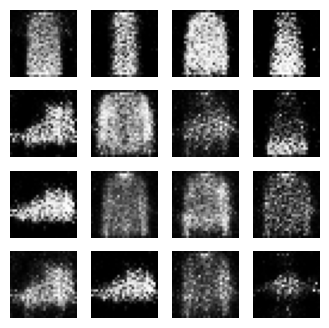

In [16]:
NUM_EPOCHS = 20  # Number of epochs

# Create an instance of GANMonitor
monitor = GANMonitor(num_img=16, latent_dim=LATENT_DIM)

# Initialize TensorBoard writer
writer = SummaryWriter('runs/GAN_experiment')


# Training loop
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real_images, _) in enumerate(data_loader):  # Replace train_loader with your DataLoader
        real_images = real_images.to(device) # Move real_images to the appropriate device

        # Train the GAN model for one batch
        training_stats = gan(real_images)

        writer.add_scalar('Loss/Discriminator', training_stats['d_loss'], epoch * len(data_loader) + batch_idx)
        writer.add_scalar('Loss/Generator', training_stats['g_loss'], epoch * len(data_loader) + batch_idx)

    # Calculate and print the accuracy metrics for the current epoch
    metrics = gan.compute_metrics(real_images)
    print(f"Epoch [{epoch}/{NUM_EPOCHS}] - D Loss: {training_stats['d_loss']:.6f}, G Loss: {training_stats['g_loss']:.6f}")
    print(f"Real Accuracy: {metrics['real_accuracy']:.6f}, Fake Accuracy: {metrics['fake_accuracy']:.6f}")

    writer.add_scalar('Accuracy/Real', metrics['real_accuracy'], epoch)
    writer.add_scalar('Accuracy/Fake', metrics['fake_accuracy'], epoch)


    # Call the GANMonitor callback to visualize generated images at the end of each epoch
    monitor.on_epoch_end(epoch, generator)

# After training, save the generator model
monitor.on_train_end(generator, discriminator)

In [17]:

load_dir = '/project/jacobcha/nk643/gans/checkpoints/normal-gan'
generator.load_state_dict(torch.load(f'{load_dir}/generator.pth'))
discriminator.load_state_dict(torch.load(f'{load_dir}/discriminator.pth'))

# Move models to the correct device
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [18]:
gan = GAN(discriminator, generator, LATENT_DIM)

# Compile the DCGAN model
gan.compile(optimizer_D, optimizer_G, loss_fn)



Epoch [20/40] - D Loss: 0.466576, G Loss: 1.588092
Real Accuracy: 0.708333, Fake Accuracy: 0.875000


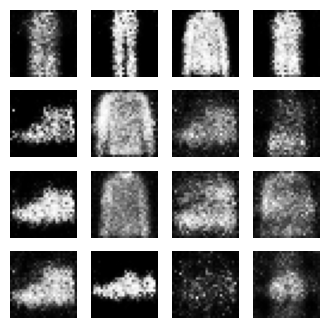

Epoch [21/40] - D Loss: 0.433799, G Loss: 1.678186
Real Accuracy: 0.802083, Fake Accuracy: 0.895833


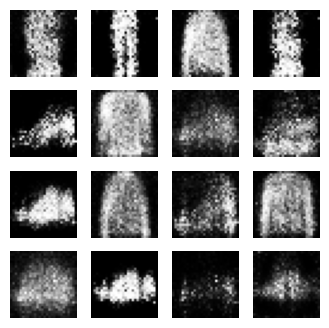

Epoch [22/40] - D Loss: 0.437385, G Loss: 1.528036
Real Accuracy: 0.739583, Fake Accuracy: 0.895833


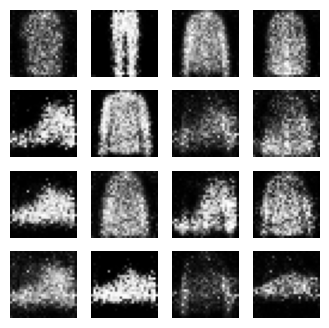

Epoch [23/40] - D Loss: 0.534926, G Loss: 1.456947
Real Accuracy: 0.541667, Fake Accuracy: 0.739583


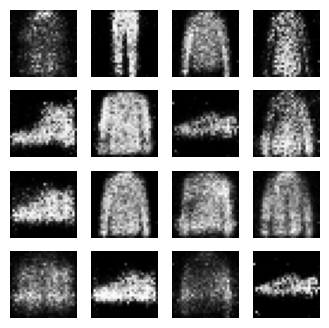

Epoch [24/40] - D Loss: 0.596223, G Loss: 1.242026
Real Accuracy: 0.739583, Fake Accuracy: 0.729167


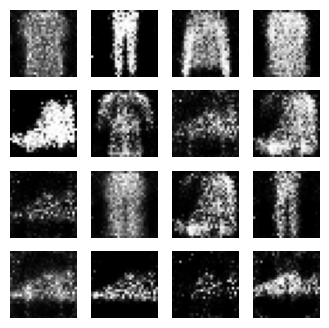

Epoch [25/40] - D Loss: 0.553007, G Loss: 1.234178
Real Accuracy: 0.770833, Fake Accuracy: 0.760417


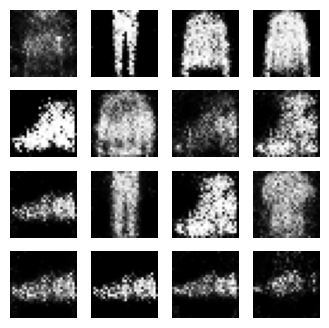

Epoch [26/40] - D Loss: 0.569198, G Loss: 1.490895
Real Accuracy: 0.718750, Fake Accuracy: 0.750000


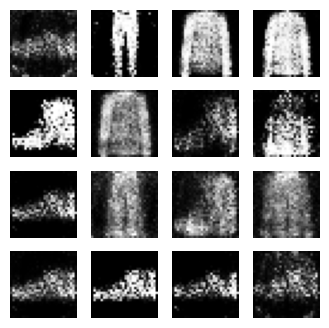

Epoch [27/40] - D Loss: 0.407073, G Loss: 1.548349
Real Accuracy: 0.770833, Fake Accuracy: 0.895833


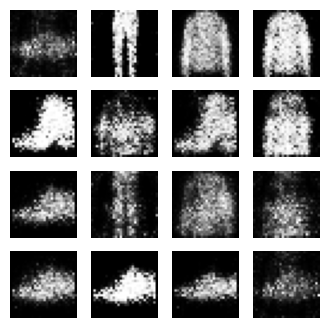

Epoch [28/40] - D Loss: 0.519928, G Loss: 1.306228
Real Accuracy: 0.697917, Fake Accuracy: 0.791667


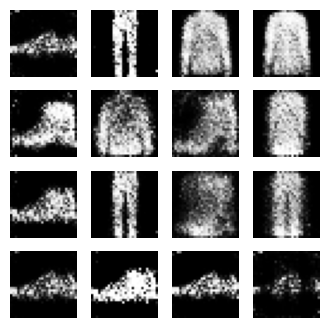

Epoch [29/40] - D Loss: 0.616716, G Loss: 1.291867
Real Accuracy: 0.614583, Fake Accuracy: 0.906250


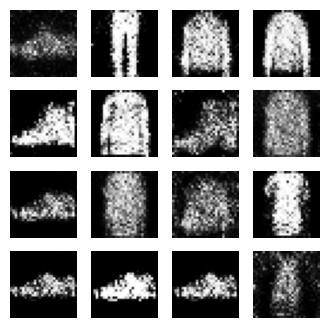

Epoch [30/40] - D Loss: 0.859037, G Loss: 0.964974
Real Accuracy: 0.447917, Fake Accuracy: 0.562500


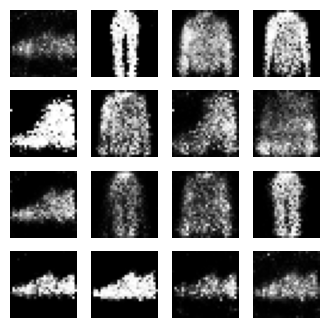

Epoch [31/40] - D Loss: 0.533147, G Loss: 1.363667
Real Accuracy: 0.645833, Fake Accuracy: 0.833333


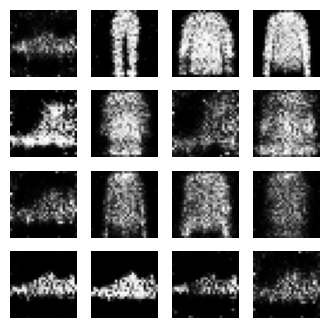

Epoch [32/40] - D Loss: 0.496861, G Loss: 1.326500
Real Accuracy: 0.708333, Fake Accuracy: 0.875000


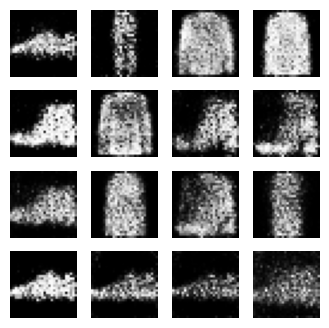

Epoch [33/40] - D Loss: 0.582012, G Loss: 1.400136
Real Accuracy: 0.697917, Fake Accuracy: 0.677083


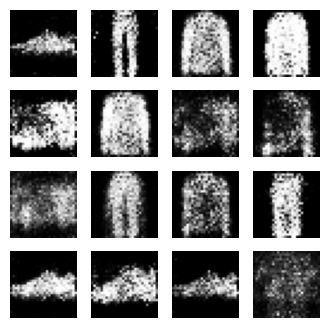

Epoch [34/40] - D Loss: 0.420484, G Loss: 1.393987
Real Accuracy: 0.781250, Fake Accuracy: 0.812500


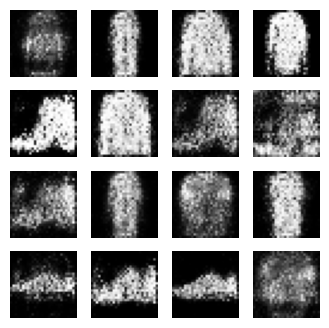

Epoch [35/40] - D Loss: 0.562950, G Loss: 1.129218
Real Accuracy: 0.687500, Fake Accuracy: 0.843750


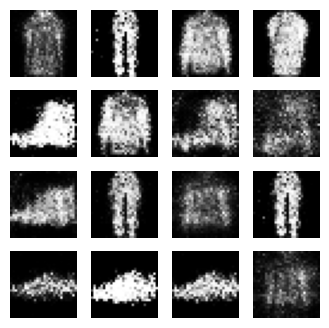

Epoch [36/40] - D Loss: 0.542729, G Loss: 1.296559
Real Accuracy: 0.666667, Fake Accuracy: 0.854167


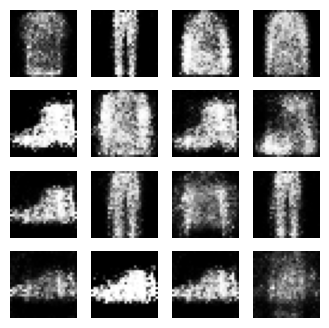

Epoch [37/40] - D Loss: 0.526358, G Loss: 1.160194
Real Accuracy: 0.729167, Fake Accuracy: 0.739583


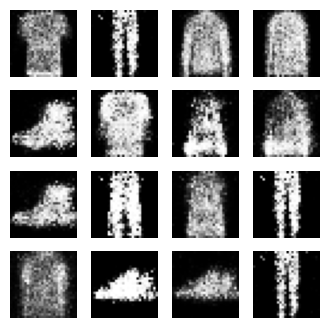

Epoch [38/40] - D Loss: 0.560236, G Loss: 1.331777
Real Accuracy: 0.656250, Fake Accuracy: 0.781250


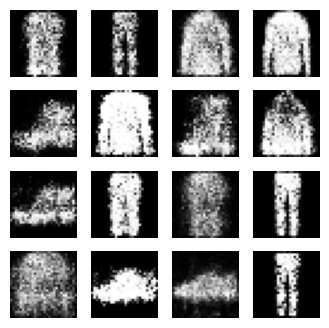

Epoch [39/40] - D Loss: 0.539806, G Loss: 1.150565
Real Accuracy: 0.760417, Fake Accuracy: 0.645833


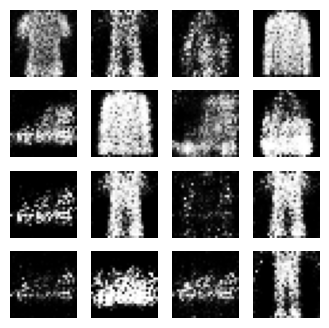

In [19]:
ADD_NUM_EPOCHS = 20  # Number of epochs
writer = SummaryWriter('runs/GAN_experiment')
# Create an instance of GANMonitor
# Training loop
for epoch in range(NUM_EPOCHS, NUM_EPOCHS + ADD_NUM_EPOCHS):
    for batch_idx, (real_images, _) in enumerate(data_loader):  # Replace train_loader with your DataLoader
        real_images = real_images.to(device) # Move real_images to the appropriate device

        # Train the GAN model for one batch
        training_stats = gan(real_images)
        writer.add_scalar('Loss/Discriminator', training_stats['d_loss'], epoch * len(data_loader) + batch_idx)
        writer.add_scalar('Loss/Generator', training_stats['g_loss'], epoch * len(data_loader) + batch_idx)

    # Calculate and print the accuracy metrics for the current epoch
    metrics = gan.compute_metrics(real_images)
    print(f"Epoch [{epoch}/{NUM_EPOCHS + ADD_NUM_EPOCHS}] - D Loss: {training_stats['d_loss']:.6f}, G Loss: {training_stats['g_loss']:.6f}")
    print(f"Real Accuracy: {metrics['real_accuracy']:.6f}, Fake Accuracy: {metrics['fake_accuracy']:.6f}")
    writer.add_scalar('Accuracy/Real', metrics['real_accuracy'], epoch)
    writer.add_scalar('Accuracy/Fake', metrics['fake_accuracy'], epoch)
    


    # Call the GANMonitor callback to visualize generated images at the end of each epoch
    monitor.on_epoch_end(epoch, generator)

# After training, save the generator model
monitor.on_train_end(generator, discriminator)

In [20]:
writer.close()

In [16]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [17]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)